## 1.2.4b. overlap Baccin dataset

In this Notebook we will compare our dataset with the dataset published in Baccin et al. 2019 (https://doi.org/10.1038/s41556-019-0439-6). Their preprocessed and filtered count matrix can be found using GEO code GSE122465 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE122465). Here, you can download the `FilteredCounts10x.csv` file. This file includes only the count matrix, but not the cluster assignments for each cell. The assigned clusters, and the t-SNE coordinates can be found in the Seurat object that is part of the Supplementary Data (see the publication). You can use R script 1.2.4a to extract the clusters and t-SNE coordinates yourself, but you can also use the files `clusters.csv` and `tsne_coordinates.csv` in the `data/public_datasets/Baccin_2019` folder on the Github repository.


In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for making sparse matrix from dense

# import own functions
from utils import *

### Load data

First, we load the preprocessed control subset (as filtered in notebook 1.1).

In [2]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

Then, we load the Baccin data and apply some preprocessing/filtering steps that we have also applied to the control subset.

In [3]:
### load haas data in dataframe
baccin_data_path = "../data/public_datasets/Baccin_2019/FilteredCounts10x.csv"
baccin_data = pd.read_csv(baccin_data_path, header=0, index_col=0)
baccin_data = baccin_data.T

In [4]:
### create Anndata object with Baccin data
adata_baccin = ad.AnnData(X=baccin_data)

In [5]:
### make sparse matrix
adata_baccin.X = scipy.sparse.csr_matrix(baccin_data.values)

In [6]:
### preprocess Baccin data
adata_baccin = filter_data(adata_baccin, mito_perc=5, min_genes=700, no_doublet=False, no_negative=False)

Trying to set attribute `.obs` of view, copying.


In [7]:
### add clusters to Baccin data
clusters_path = "../data/public_datasets/Baccin_2019/clusters.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
adata_baccin.obs["clusters_baccin"] = clusters

In [8]:
### add tsne coordinates to Baccin data
coordinates_path = "../data/public_datasets/Baccin_2019/tsne_coordinates.csv"
coordinates = pd.read_csv(coordinates_path, index_col=0)
adata_baccin.obsm["X_tsne"] = coordinates.loc[adata_baccin.obs_names.values]

Here, we will plot the Baccind dataset in the t-SNE plot from the original publication.

... storing 'clusters_baccin' as categorical


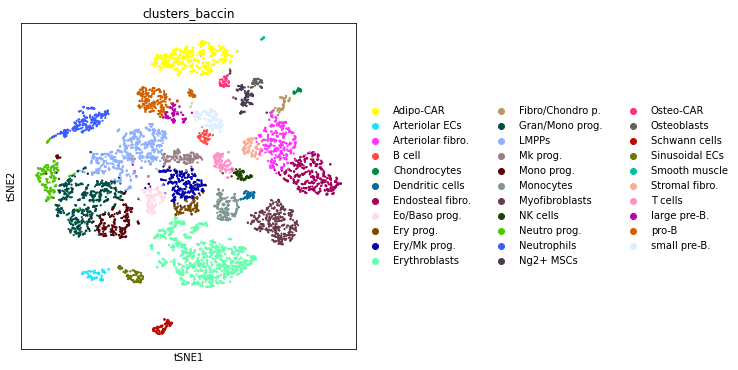

In [9]:
### plot Baccin data
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.tsne(adata_baccin, color="clusters_baccin", size=20, show=False, ax=axs)
plt.show()

### Combine control and Baccin dataset
To compare the control and Baccin dataset, we have to combine the datasets. First we will select the highly variable genes (HVGs) for both datasets individually. We will select only those genes in both datasets. Then, we combine the two datasets. Afterwards we normalize the dataset and perform a batch correction (between the control subset and the Baccin dataset). These steps are very similar to the preprocessing that we perform on the complete HSPC dataset in the Jupyter Notebook 1.3.

In [10]:
### find shared genes
shared_genes = adata.var_names.intersection(adata_baccin.var_names)

### subset for shared genes
adata = adata[:, shared_genes]
adata_baccin = adata_baccin[:, shared_genes]

In [11]:
### get HVGs for both datasets
hvgs_HSPC = get_hvgs(adata, no_of_hvgs=2000, theta=100)
hvgs_baccin = get_hvgs(adata_baccin, no_of_hvgs=2000, theta=100)
hvgs = np.unique(np.concatenate([hvgs_HSPC, hvgs_baccin]))

### subset for HVGs
adata = adata[:, hvgs]
adata_baccin = adata_baccin[:, hvgs]

In [12]:
### combine datasets
combined = adata.concatenate(adata_baccin, batch_key="dataset", 
                             batch_categories=["control", "Baccin"])

In [13]:
### L2 normalize dataset
combined.X = sk.preprocessing.normalize(combined.X, norm='l2')

In [14]:
_ = integrate_datasets(combined, combined.X.todense(), batch_key="dataset", n_comps=100)

[[0.         0.55133387]
 [0.         0.        ]]
Processing datasets control <=> Baccin


### UMAP representation of data
Here we will use the integrated data to calculate the UMAP representation of the 2 datasets combined.

In [15]:
### calculate NN
sc.pp.neighbors(combined, n_neighbors=20, use_rep = "X_scanorama_reduced")

In [16]:
### calculate UMAP 
sc.tl.umap(combined)

... storing 'hashtags' as categorical
... storing 'clusters' as categorical
... storing 'clusters_baccin' as categorical


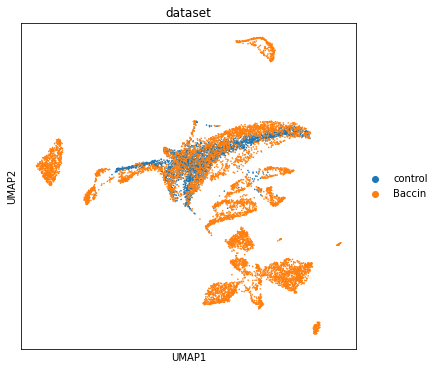

In [17]:
### plot both datasets in UMAP 
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.umap(combined, color="dataset", size=10, ax=axs, show=False)
plt.show()

In [18]:
### set the correct colours for each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
color_dict['nan']="#cfcfcf"
combined.uns["clusters_colors"] = combined.obs["clusters"].cat.categories.map(color_dict).values

color_dict = dict(zip(adata_baccin.obs["clusters_baccin"].cat.categories, adata_baccin.uns["clusters_baccin_colors"]))
color_dict['nan']="#cfcfcf"
combined.uns["clusters_baccin_colors"] = combined.obs["clusters_baccin"].cat.categories.map(color_dict).values

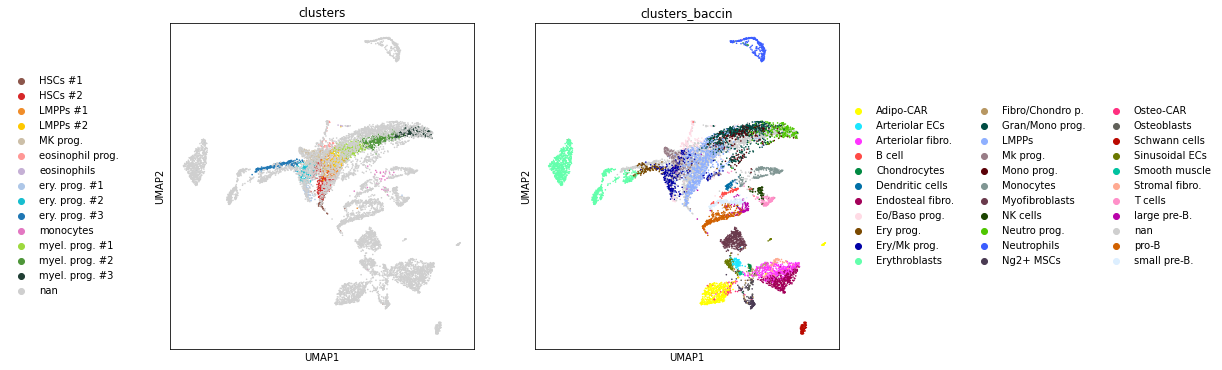

In [19]:
### plot both datasets 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
sc.pl.umap(combined, color="clusters", size=10, ax=axs[0], show=False)
sc.pl.umap(combined, color="clusters_baccin", size=10, ax=axs[1], show=False)
axs[0].legend(bbox_to_anchor=(-0.55, 0.5), loc='center left', framealpha=0.0)
plt.show()

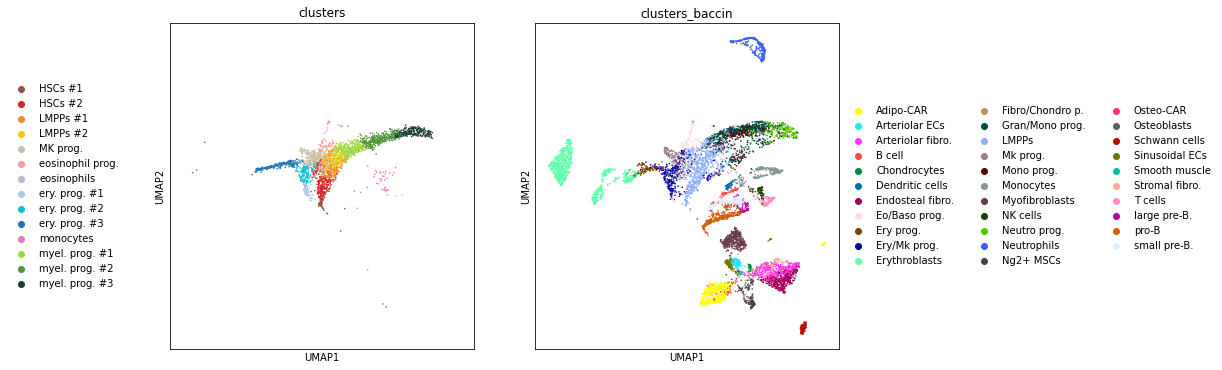

In [20]:
### plot both datasets seperately with colors for clusters
fig, axs = plt.subplots(1, 2, figsize=(12,6))
sc.pl.umap(combined[combined.obs["dataset"]=="control"], color="clusters", size=10, ax=axs[0], show=False)
sc.pl.umap(combined[combined.obs["dataset"]=="Baccin"], color="clusters_baccin", size=10, ax=axs[1], show=False)
axs[0].legend(bbox_to_anchor=(-0.55, 0.5), loc='center left', framealpha=0.0)
axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_xlim(axs[1].get_xlim())
plt.show()

### Label transfer

Here we transfer the labels from the Baccin dataset to the control subset. We use the reduced Scanorama space to find the nearest neighbours of each control cell in the Baccin dataset. Then, we assign the label that is most common among the nearest neighbours to the selected cell.

In [21]:
### transfer labels from Baccin dataset to control subset
labels = label_transfer(combined, batch_key="dataset", label_key="clusters_baccin",
                        reference="Baccin", query="control", no_neighbours=10)

In [22]:
### add transferred labels to control subset
adata.obs["transferred_labels"] = labels.values

Trying to set attribute `.obs` of view, copying.


In [23]:
### set the correct colours for each cluster
color_dict = dict(zip(adata_baccin.obs["clusters_baccin"].cat.categories, adata_baccin.uns["clusters_baccin_colors"]))
adata.uns['transferred_labels_colors'] = adata.obs["transferred_labels"].cat.categories.map(color_dict).values

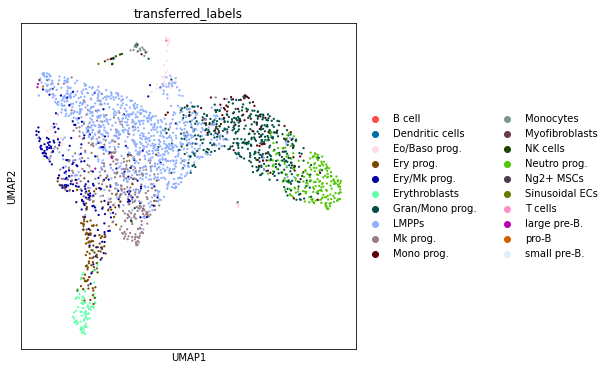

In [24]:
### UMAP with transferred labels
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.umap(adata, color="transferred_labels", size=20, show=False, ax=axs)
plt.show()